In [252]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

In [253]:
net_heat = ContTempNetwork.load('fig3_network250_temporal_heat')
net_network_static_weighted_heat = ContTempNetwork.load('fig3_network250_heat')

In [254]:
slow_lamdas=np.logspace(-10,-4,200)
between_slow_lamdas=np.linspace(-10,-4,200)

lamdas = np.logspace(-5,0,200)
between_lamdas=np.linspace(-5,0,200)

fast_lamdas = np.logspace(-2,2,200)
between_fast_lamdas=np.linspace(-2,2,200)

lamdas_plot = np.logspace(-2.5,0,6)

In [255]:
slow_lamdas[0] = 1.00000000e-10

In [256]:
with open('//scratch/tmp/180/skoove/experiment250_static_weighted_heat/clusters_sam_slow', 'rb') as f:
    multi_res_static_weighted_heat_sam = pickle.load(f)
    
avg_csize_forw_static_weighted_heat_sam = [np.mean([len(c) for c in \
                   multi_res_static_weighted_heat_sam[lamda] if len(c)>1]) for lamda in slow_lamdas]

NVI_forw_static_weighted_heat_sam = [avg_norm_var_information(multi_res_static_weighted_heat_sam[lamda]) for lamda in slow_lamdas]

In [257]:
lamdas[0] = 9.999999999999999e-06

In [258]:
with open('//scratch/tmp/180/skoove/experiment250_temporal_heat/clusters', 'rb') as f:
    multi_res_heat = pickle.load(f)
    
avg_csize_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas]

# Derivatives

In [259]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [260]:
vNS_static_weighted_heat_end = []
for i, lamda in enumerate(slow_lamdas):
    with open(f'/scratch/tmp/180/skoove/experiment250_static_weighted_heat/vNS_slow/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_static_weighted_heat_end.append(S[list(S.keys())[0]][0])

# vNSsam_static_weighted_heat_end = []
# for i, lamda in enumerate(slow_lamdas):
#     try:
#         with open(f'/scratch/tmp/180/skoove/experiment250_static_weighted_heat/vNSend/vNS{lamda:.7f}', 'rb') as f:
#             S = pickle.load(f)['vNS']
#             vNSsam_static_weighted_heat_end.append(S[list(S.keys())[0]][0])
#     except IOError:
#         vNSsam_static_weighted_heat_end.append(vNSsam_static_weighted_heat_end[-1])

vNS_heat_end = []
for i, lamda in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment250_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end.append(S[list(S.keys())[0]][0])

In [261]:
v1 = vNS_static_weighted_heat_end
w1 = vNS_heat_end
#z1 = vNSsam_static_weighted_heat_end
v2 = between_slow_lamdas
v3 = between_fast_lamdas
ds_dt = derivative(v1, v2)
ds7_dt = derivative(w1, v3)
#dssam_dt = derivative(z1, v2)

# Entropy Plot

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


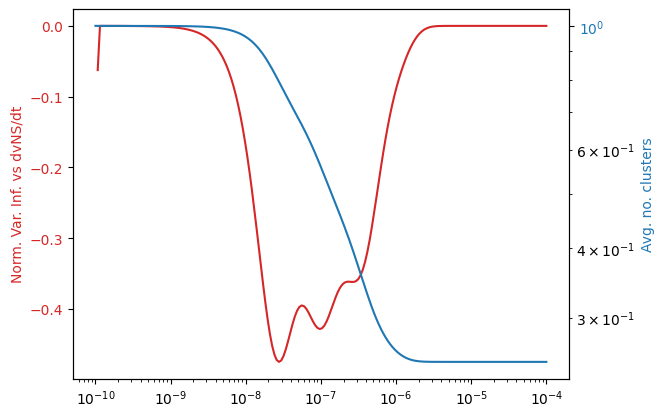

In [262]:
####### Enotrpy Plot
fig, ax = plt.subplots()
color = 'tab:red'
ax.plot(slow_lamdas[1:], ds_dt, color=color, label='dvNS/dt')

ax.set_xscale('log')
ax.set_ylabel('Norm. Var. Inf. vs dvNS/dt', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(slow_lamdas, vNS_static_weighted_heat_end, color=color, label='vNS')
ax2.set_yscale('log')

ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

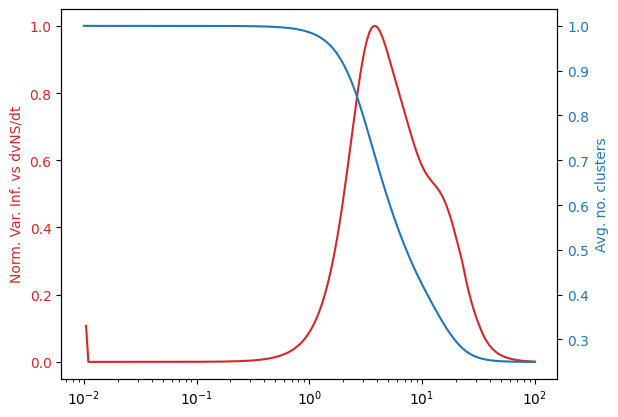

In [263]:
####### Enotrpy Plot
fig, ax = plt.subplots()
color = 'tab:red'
ax.plot(fast_lamdas[1:], ds7_dt / min(ds7_dt), color=color, label='dvNSdt')

ax.set_xscale('log')
ax.set_ylabel('Norm. Var. Inf. vs dvNS/dt', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(fast_lamdas, vNS_heat_end / max(vNS_heat_end), color=color, label='vNS')

ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

# Final Plot

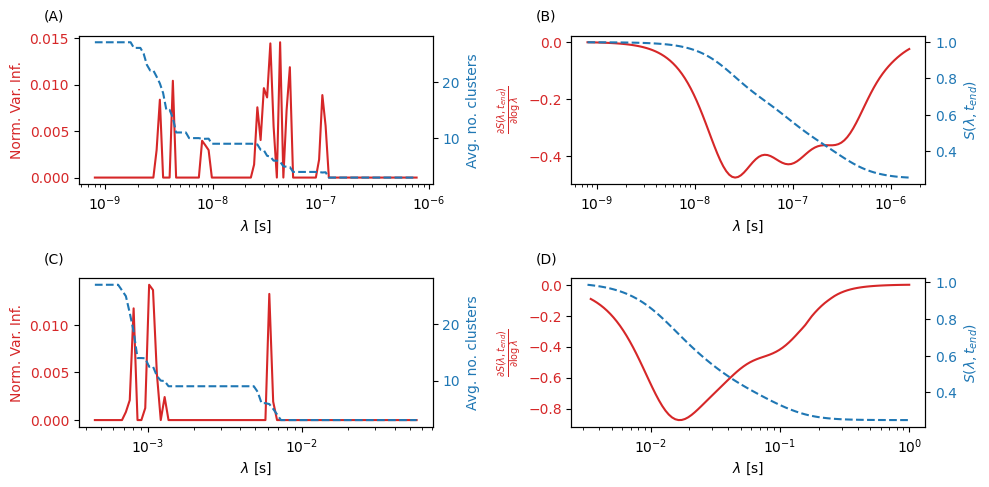

In [264]:
fig, axs = plt.subplots(2,2, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs[0,0].plot(slow_lamdas[30:130], NVI_forw_static_weighted_heat_sam[30:130], color=color, label='static norm NVI: sam')

axs[0,0].set_xscale('log')
axs[0,0].set_xlabel(r'$\lambda$ [s]')
axs[0,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[0,0].tick_params(axis='y', labelcolor=color)
axs[0,0].text(-0.1,1.1, '(A)', transform=axs[0,0].transAxes)

ax1 = axs[0,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(slow_lamdas[30:130], avg_csize_forw_static_weighted_heat_sam[30:130], '--', color=color, label='edge-centric: sam')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

####### Second Plot

color = 'tab:red'
axs[0,1].plot(slow_lamdas[30:140], ds_dt[30:140], color=color, label='dvNS/dt')

axs[0,1].set_xscale('log')
axs[0,1].set_xlabel(r'$\lambda$ [s]')
axs[0,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0,1].tick_params(axis='y', labelcolor=color)
axs[0,1].text(-0.1,1.1, '(B)', transform=axs[0,1].transAxes)

ax2 = axs[0,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(slow_lamdas[30:140], vNS_static_weighted_heat_end[30:140], '--', color=color, label='vNS')

ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


####### Third Plot
color = 'tab:red'
axs[1,0].plot(lamdas[66:-50], NVI_forw_heat[66:-50], color=color)

axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$\lambda$ [s]')
axs[1,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[1,0].tick_params(axis='y', labelcolor=color)
axs[1,0].text(-0.1,1.1, '(C)', transform=axs[1,0].transAxes)

ax3 = axs[1,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas[66:-50], avg_csize_forw_heat[66:-50], '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axs[1,1].plot(lamdas[101:], ds7_dt[100:], color=color, label='dvNSdt')

axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$\lambda$ [s]')

axs[1,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1,1].tick_params(axis='y', labelcolor=color)
axs[1,1].text(-0.1,1.1, '(D)', transform=axs[1,1].transAxes)

ax4 = axs[1,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas[100:], vNS_heat_end[100:], '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)




#fig.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('./figNetSci.eps', format='eps')
plt.show()

# Last Plot

In [265]:
selected_lamdas = np.logspace(-2.5,0,9)
sample_times0_50 = [len(net_heat.times)-3, len(net_heat.times)-2] # list(range(51)) #list(np.arange(0, len(net_heat.times), 30))
sample_times = list(np.arange(0, len(net_heat.times), 10))

In [266]:
# vNS_heat_end = []
# for i, lamda in enumerate(selected_lamdas):
#     with open(f'//scratch/tmp/180/skoove/experiment250_temporal_heat/vNSplot/vNS{lamda:.11f}', 'rb') as f:
#         S = pickle.load(f)
#         vNS_heat_end.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


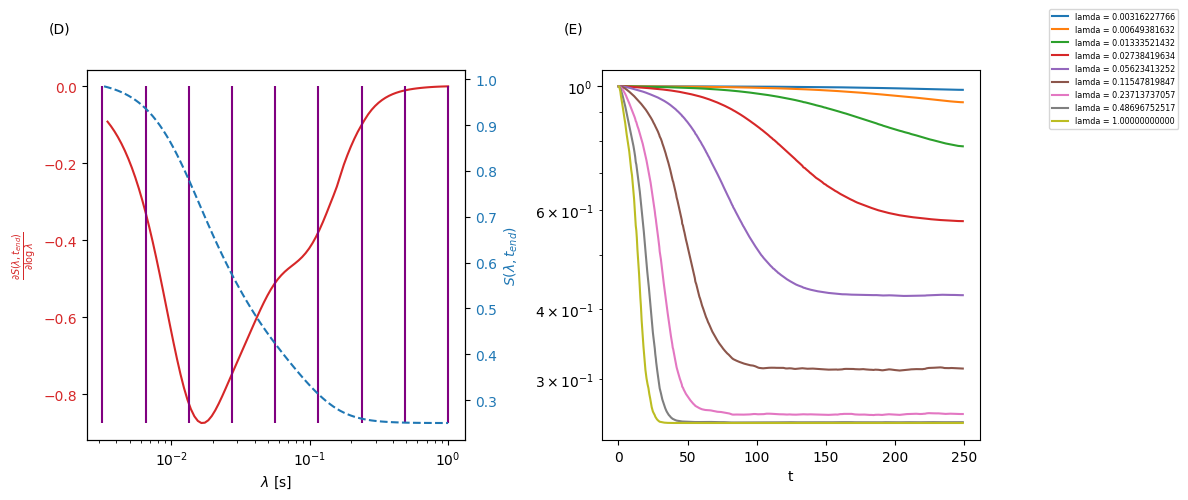

In [268]:
fig, axs = plt.subplots(1,2, sharex=False, figsize=(10, 5))


####### Fourth Plot

color = 'tab:red'
axs[0].plot(lamdas[101:], ds7_dt[100:], color=color)

axs[0].set_xscale('log')
axs[0].set_xlabel(r'$\lambda$ [s]')

axs[0].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].text(-0.1,1.1, '(D)', transform=axs[0].transAxes)

min_ds7dt = np.min(ds7_dt[100:])
max_ds7dt = np.max(ds7_dt[100:])


axs[0].vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt], ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt], colors='purple')

ax1 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas[100:], vNS_heat_end[100:], '--', color=color)

ax1.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

#Plot 5

for i, lamda in enumerate(selected_lamdas):
    axs[1].plot(net_heat.times[sample_times], vNS_heat0_50[i], label='lamda = ' + f'{lamda:.11f}')
    #axs[1].set_xscale('log')
    axs[1].set_xlabel('t')
    axs[1].set_yscale('log')
axs[1].text(-0.1,1.1, '(E)', transform=axs[1].transAxes)


fig.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('/home/b/skoove/Desktop/plots250/choice_selected_lamdas.eps', format='eps')
plt.show()

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotx/_optimize.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  s[mask] = numpy.linalg.lstsq(AtA[mask][:, mask], Atb[mask], rcond=None)[0]
/tmp/ipykernel_18834/942591803.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fi

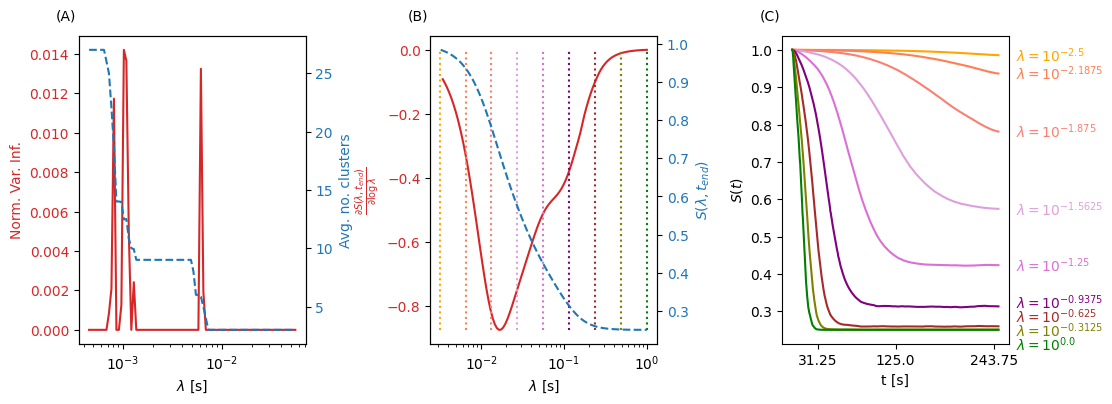

In [334]:
# Create a 2x3 grid of subplots with specific figure size
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.55)


####### Third Plot
color = 'tab:red'
axsc = plt.subplot(gs[0,0])
axsc.plot(lamdas[66:-50], NVI_forw_heat[66:-50], color=color)

axsc.set_xscale('log')
axsc.set_xlabel(r'$\lambda$ [s]')
axsc.set_ylabel('Norm. Var. Inf.', color=color)
axsc.tick_params(axis='y', labelcolor=color)
axsc.text(-0.1,1.05, '(A)', transform=axsc.transAxes)

ax3 = axsc.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas[66:-50], avg_csize_forw_heat[66:-50], '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axsd = plt.subplot(gs[0,1])
axsd.plot(lamdas[101:], ds7_dt[100:], color=color, label='dvNSdt')

axsd.set_xscale('log')
axsd.set_xlabel(r'$\lambda$ [s]')

axsd.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axsd.tick_params(axis='y', labelcolor=color)
axsd.text(-0.1,1.05, '(B)', transform=axsd.transAxes)

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green']
axsd.vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt],
            ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt],
            colors= list_colors, linestyles='dotted')

ax4 = axsd.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas[100:], vNS_heat_end[100:], '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)


#Plot 5
list_annotate_y = []
for i, lamda in enumerate(selected_lamdas):
    list_annotate_y.append(np.mean(vNS_heat0_50[i]))

shift_annotate_y = [0.01, 0.03, 0.02, -0.05, -0.4, -0.35, -0.05, -0.05, -0.06]

axse = plt.subplot(gs[0,2])
for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-2.5,0,9)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)
    axse.set_xlabel('t [s]')
    #axse.annotate(text = r'$\lambda = e^{%s}$' % exponent, xy=[100, list_annotate_y[i]], xytext=[105, list_annotate_y[i]+shift_annotate_y[1]-0.05], color='magenta')
axse.text(-0.1,1.05, '(C)', transform=axse.transAxes)
axse.set_ylabel(r'$S(t)$')
matplotx.line_labels()
#axse.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1))


deltat1 =250/4
# axse.vlines(x = [0.5*deltat1, 2*deltat1, 3.9*deltat1],
#             ymin = [np.min(vNS_heat0_50), np.min(vNS_heat0_50), np.min(vNS_heat0_50)], ymax = [np.max(vNS_heat0_50), np.max(vNS_heat0_50), np.max(vNS_heat0_50)], colors='purple')
plt.xticks([0.5*deltat1, 2*deltat1, 3.9*deltat1,],[str(0.5*deltat1), str(2*deltat1), str(3.9*deltat1)])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('./figNetSci.eps', format='eps', dpi=300)
plt.show()